In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 26.6 MB/s 
     |████████████████████████████████| 258 kB 30.3 MB/s 
     |████████████████████████████████| 1.8 MB 66.7 MB/s 
     |████████████████████████████████| 103 kB 71.8 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 7
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()

print(set(train_ids) & set(valid_ids))

tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data, CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Num of unique id: 569406
Num of train data: 13928057
Pos rate: 0.07242905453359359
                        id          match_id     kdist  kneighbors  \
2271553   E_fd464ba1740098  E_e9f184d83cae1e  0.007594         3.0   
2195812   E_db1da0832b0edb  E_43d12cd75a508f  0.003153         3.0   
6242880   E_f6b56f1f995bb8  E_559775ec266daa  0.002581        10.0   
9817306   E_3daed89cf926d8  E_7d12548cb02d23  0.001735        17.0   
11950281  E_92c117b8a31433  E_8f8f0ab8d049d3       NaN         NaN   

          kdist_country  kneighbors_country  label  
2271553        0.006657                 2.0      0  
2195812        0.003124                 3.0      0  
6242880        0.002541                10.0      0  
9817306        0.001725                17.0      0  
11950281       0.040197                12.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 569406
Unique id: 569406
IoU score: 0.9231233344021228


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)

        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)

        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/7 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0436938
[100]	valid_0's binary_logloss: 0.042116
[150]	valid_0's binary_logloss: 0.0411747
[200]	valid_0's binary_logloss: 0.0406366
[250]	valid_0's binary_logloss: 0.0402133
[300]	valid_0's binary_logloss: 0.0398421
[350]	valid_0's binary_logloss: 0.03947
[400]	valid_0's binary_logloss: 0.0392071
[450]	valid_0's binary_logloss: 0.0389006
[500]	valid_0's binary_logloss: 0.0386521
[550]	valid_0's binary_logloss: 0.0383983
[600]	valid_0's binary_logloss: 0.0381991
[650]	valid_0's binary_logloss: 0.0379912
[700]	valid_0's binary_logloss: 0.0377832
[750]	valid_0's binary_logloss: 0.0375865
[800]	valid_0's binary_logloss: 0.0373892
[850]	valid_0's binary_logloss: 0.0372192
[900]	valid_0's binary_logloss: 0.0370543
[950]	valid_0's binary_logloss: 0.0368852
[1000]	valid_0's binary_logloss: 0.0367203
[1050]	valid_0's binary_logloss: 0.0365994
[1100]	valid_0's binary_logloss: 0.036449
[1150]	valid_0's binary_logloss: 0.0363139
[1200]	valid_0's binar

In [ ]:
train_data["pred"] = oof[:, -1]

In [ ]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

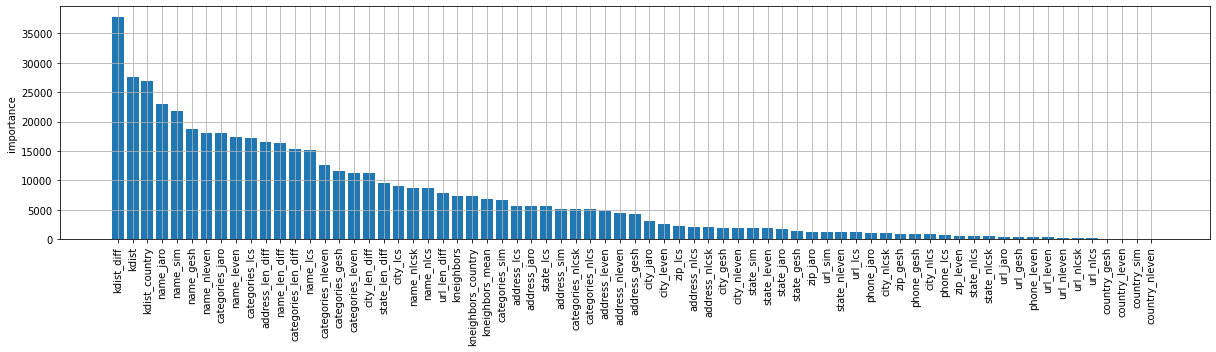

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 21.7 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 210 kB 37.3 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 112 kB 46.2 MB/s 
     |████████████████████████████████| 146 kB 46.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=95beb961fbd01c3330efd44ac60da6fbc463495e30e734b4729e7dfba388128a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-22 13:18:06,459] A new study created in memory with name: no-name-19d27a1f-673e-4e3a-8d00-24f892a3ce70
[I 2022-05-22 13:18:27,277] Trial 0 finished with value: 0.8803645724292825 and parameters: {'threshold': 0.7474836042694827}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.880365


[I 2022-05-22 13:18:51,272] Trial 1 finished with value: 0.6590925203473288 and parameters: {'threshold': 0.007649291408380887}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.659093


[I 2022-05-22 13:19:13,421] Trial 2 finished with value: 0.7343511507423943 and parameters: {'threshold': 0.020103892592687744}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.734351


[I 2022-05-22 13:19:34,244] Trial 3 finished with value: 0.7495898775800816 and parameters: {'threshold': 0.02500283667433889}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.749590


[I 2022-05-22 13:19:54,818] Trial 4 finished with value: 0.8695074664620467 and parameters: {'threshold': 0.8555508295041828}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.869507


[I 2022-05-22 13:20:13,608] Trial 5 finished with value: 0.8745448188380819 and parameters: {'threshold': 0.8181936072843391}. Best is trial 0 with value: 0.8803645724292825.


CV: 0.874545


[I 2022-05-22 13:20:33,457] Trial 6 finished with value: 0.8829863381642347 and parameters: {'threshold': 0.6944782720532242}. Best is trial 6 with value: 0.8829863381642347.


CV: 0.882986


[I 2022-05-22 13:20:53,964] Trial 7 finished with value: 0.852176199815398 and parameters: {'threshold': 0.15999218835043028}. Best is trial 6 with value: 0.8829863381642347.


CV: 0.852176


[I 2022-05-22 13:21:15,226] Trial 8 finished with value: 0.861375967734912 and parameters: {'threshold': 0.20163635030075056}. Best is trial 6 with value: 0.8829863381642347.


CV: 0.861376


[I 2022-05-22 13:21:34,548] Trial 9 finished with value: 0.8755366867885587 and parameters: {'threshold': 0.3106517902209305}. Best is trial 6 with value: 0.8829863381642347.


CV: 0.875537


[I 2022-05-22 13:21:55,442] Trial 10 finished with value: 0.8854050796122114 and parameters: {'threshold': 0.569648988065631}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885405


[I 2022-05-22 13:22:14,522] Trial 11 finished with value: 0.8853820521862958 and parameters: {'threshold': 0.567207789872384}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885382


[I 2022-05-22 13:22:34,469] Trial 12 finished with value: 0.885368154570129 and parameters: {'threshold': 0.5458576126132767}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885368


[I 2022-05-22 13:22:54,448] Trial 13 finished with value: 0.884551392269361 and parameters: {'threshold': 0.4858405053060477}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.884551


[I 2022-05-22 13:23:13,447] Trial 14 finished with value: 0.7899337659874911 and parameters: {'threshold': 0.9916135472229646}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.789934


[I 2022-05-22 13:23:34,351] Trial 15 finished with value: 0.8850305540623058 and parameters: {'threshold': 0.5160903757658147}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885031


[I 2022-05-22 13:23:53,636] Trial 16 finished with value: 0.8818339400109385 and parameters: {'threshold': 0.40605862698740036}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.881834


[I 2022-05-22 13:24:14,274] Trial 17 finished with value: 0.8850094268272135 and parameters: {'threshold': 0.624757872903061}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885009


[I 2022-05-22 13:24:34,551] Trial 18 finished with value: 0.8824793395384628 and parameters: {'threshold': 0.41951234065871634}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.882479


[I 2022-05-22 13:24:53,722] Trial 19 finished with value: 0.885172596976208 and parameters: {'threshold': 0.610338216410357}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.885173


[I 2022-05-22 13:25:14,006] Trial 20 finished with value: 0.8762371996336417 and parameters: {'threshold': 0.3187833499547915}. Best is trial 10 with value: 0.8854050796122114.


CV: 0.876237


[I 2022-05-22 13:25:33,884] Trial 21 finished with value: 0.885433157031676 and parameters: {'threshold': 0.5723551934423055}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885433


[I 2022-05-22 13:25:54,568] Trial 22 finished with value: 0.8845457830220071 and parameters: {'threshold': 0.6495916155211415}. Best is trial 21 with value: 0.885433157031676.


CV: 0.884546


[I 2022-05-22 13:26:13,867] Trial 23 finished with value: 0.8854328213373182 and parameters: {'threshold': 0.556946479241611}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885433


[I 2022-05-22 13:26:34,870] Trial 24 finished with value: 0.882881973069449 and parameters: {'threshold': 0.43146802817766705}. Best is trial 21 with value: 0.885433157031676.


CV: 0.882882


[I 2022-05-22 13:26:53,826] Trial 25 finished with value: 0.8810217966225395 and parameters: {'threshold': 0.7365464508350549}. Best is trial 21 with value: 0.885433157031676.


CV: 0.881022


[I 2022-05-22 13:27:15,076] Trial 26 finished with value: 0.8758579407658253 and parameters: {'threshold': 0.3145757788390834}. Best is trial 21 with value: 0.885433157031676.


CV: 0.875858


[I 2022-05-22 13:27:34,231] Trial 27 finished with value: 0.8843538576467387 and parameters: {'threshold': 0.4775001736079207}. Best is trial 21 with value: 0.885433157031676.


CV: 0.884354


[I 2022-05-22 13:27:54,740] Trial 28 finished with value: 0.8734050583561694 and parameters: {'threshold': 0.8273676038838433}. Best is trial 21 with value: 0.885433157031676.


CV: 0.873405


[I 2022-05-22 13:28:13,632] Trial 29 finished with value: 0.8826468454498181 and parameters: {'threshold': 0.7020099592325668}. Best is trial 21 with value: 0.885433157031676.


CV: 0.882647


[I 2022-05-22 13:28:34,415] Trial 30 finished with value: 0.8773293599967495 and parameters: {'threshold': 0.7901920629131658}. Best is trial 21 with value: 0.885433157031676.


CV: 0.877329


[I 2022-05-22 13:28:53,580] Trial 31 finished with value: 0.8853951440973226 and parameters: {'threshold': 0.5677355990378227}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885395


[I 2022-05-22 13:29:13,568] Trial 32 finished with value: 0.8853278780320528 and parameters: {'threshold': 0.5948076365354131}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885328


[I 2022-05-22 13:29:33,438] Trial 33 finished with value: 0.8832454010307471 and parameters: {'threshold': 0.6870082065854134}. Best is trial 21 with value: 0.885433157031676.


CV: 0.883245


[I 2022-05-22 13:29:54,539] Trial 34 finished with value: 0.87979938115966 and parameters: {'threshold': 0.3679346257739405}. Best is trial 21 with value: 0.885433157031676.


CV: 0.879799


[I 2022-05-22 13:30:13,706] Trial 35 finished with value: 0.8852884619134566 and parameters: {'threshold': 0.5379457259557168}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885288


[I 2022-05-22 13:30:34,055] Trial 36 finished with value: 0.8545129464653364 and parameters: {'threshold': 0.9200350856729024}. Best is trial 21 with value: 0.885433157031676.


CV: 0.854513


[I 2022-05-22 13:30:53,406] Trial 37 finished with value: 0.8841079923465222 and parameters: {'threshold': 0.46951641421081014}. Best is trial 21 with value: 0.885433157031676.


CV: 0.884108


[I 2022-05-22 13:31:13,175] Trial 38 finished with value: 0.880133612607787 and parameters: {'threshold': 0.7516793559498394}. Best is trial 21 with value: 0.885433157031676.


CV: 0.880134


[I 2022-05-22 13:31:33,054] Trial 39 finished with value: 0.8846535053260182 and parameters: {'threshold': 0.6435568115627963}. Best is trial 21 with value: 0.885433157031676.


CV: 0.884654


[I 2022-05-22 13:31:52,948] Trial 40 finished with value: 0.8854225864675714 and parameters: {'threshold': 0.5702997669999779}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885423


[I 2022-05-22 13:32:13,716] Trial 41 finished with value: 0.8853966270026892 and parameters: {'threshold': 0.549555325291729}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885397


[I 2022-05-22 13:32:33,885] Trial 42 finished with value: 0.8851648796552691 and parameters: {'threshold': 0.5240785652240532}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885165


[I 2022-05-22 13:32:52,962] Trial 43 finished with value: 0.883904414852498 and parameters: {'threshold': 0.671902155405311}. Best is trial 21 with value: 0.885433157031676.


CV: 0.883904


[I 2022-05-22 13:33:12,842] Trial 44 finished with value: 0.8853663428536742 and parameters: {'threshold': 0.5922987419161151}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885366


[I 2022-05-22 13:33:33,797] Trial 45 finished with value: 0.8839601181775638 and parameters: {'threshold': 0.46500892025132884}. Best is trial 21 with value: 0.885433157031676.


CV: 0.883960


[I 2022-05-22 13:33:53,616] Trial 46 finished with value: 0.8647465550161452 and parameters: {'threshold': 0.22119150567810458}. Best is trial 21 with value: 0.885433157031676.


CV: 0.864747


[I 2022-05-22 13:34:14,358] Trial 47 finished with value: 0.8849605258993402 and parameters: {'threshold': 0.5069810334238268}. Best is trial 21 with value: 0.885433157031676.


CV: 0.884961


[I 2022-05-22 13:34:34,488] Trial 48 finished with value: 0.8854173738979209 and parameters: {'threshold': 0.5619799139682746}. Best is trial 21 with value: 0.885433157031676.


CV: 0.885417


[I 2022-05-22 13:34:55,596] Trial 49 finished with value: 0.8797532096658186 and parameters: {'threshold': 0.3670646726975546}. Best is trial 21 with value: 0.885433157031676.


CV: 0.879753


[I 2022-05-22 13:35:14,425] Trial 50 finished with value: 0.8813778149972141 and parameters: {'threshold': 0.7291052075322919}. Best is trial 21 with value: 0.885433157031676.


CV: 0.881378


[I 2022-05-22 13:35:34,524] Trial 51 finished with value: 0.8854333310329479 and parameters: {'threshold': 0.5776787819546013}. Best is trial 51 with value: 0.8854333310329479.


CV: 0.885433


[I 2022-05-22 13:35:55,356] Trial 52 finished with value: 0.8853609180799469 and parameters: {'threshold': 0.5895034231873388}. Best is trial 51 with value: 0.8854333310329479.


CV: 0.885361


[I 2022-05-22 13:36:14,426] Trial 53 finished with value: 0.8844718041899724 and parameters: {'threshold': 0.6527293783008234}. Best is trial 51 with value: 0.8854333310329479.


CV: 0.884472


[I 2022-05-22 13:36:35,296] Trial 54 finished with value: 0.8850036289524338 and parameters: {'threshold': 0.6252428022486602}. Best is trial 51 with value: 0.8854333310329479.


CV: 0.885004


[I 2022-05-22 13:36:54,561] Trial 55 finished with value: 0.8854535781174508 and parameters: {'threshold': 0.5561400610054966}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885454


[I 2022-05-22 13:37:14,568] Trial 56 finished with value: 0.8833425442633072 and parameters: {'threshold': 0.44536617961253255}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.883343


[I 2022-05-22 13:37:35,378] Trial 57 finished with value: 0.8848763235308159 and parameters: {'threshold': 0.5027605256555866}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884876


[I 2022-05-22 13:37:54,656] Trial 58 finished with value: 0.8815584301335688 and parameters: {'threshold': 0.40019233913028096}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.881558


[I 2022-05-22 13:38:15,571] Trial 59 finished with value: 0.8854398494177941 and parameters: {'threshold': 0.5530086565210102}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885440


[I 2022-05-22 13:38:34,559] Trial 60 finished with value: 0.8851964560724892 and parameters: {'threshold': 0.525906047082661}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885196


[I 2022-05-22 13:38:55,436] Trial 61 finished with value: 0.8853948506526751 and parameters: {'threshold': 0.5608908524328019}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885395


[I 2022-05-22 13:39:15,536] Trial 62 finished with value: 0.8154991047212117 and parameters: {'threshold': 0.07422234570829661}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.815499


[I 2022-05-22 13:39:36,388] Trial 63 finished with value: 0.885160205877046 and parameters: {'threshold': 0.6119196211979018}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885160


[I 2022-05-22 13:39:55,434] Trial 64 finished with value: 0.8854360335956463 and parameters: {'threshold': 0.5568137780518777}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885436


[I 2022-05-22 13:40:16,376] Trial 65 finished with value: 0.8848188465869001 and parameters: {'threshold': 0.5000197057730331}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884819


[I 2022-05-22 13:40:35,388] Trial 66 finished with value: 0.8839017087777212 and parameters: {'threshold': 0.6716935574977732}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.883902


[I 2022-05-22 13:40:56,178] Trial 67 finished with value: 0.8849398135559758 and parameters: {'threshold': 0.6278811891602188}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884940


[I 2022-05-22 13:41:15,243] Trial 68 finished with value: 0.8854071764101699 and parameters: {'threshold': 0.5799503168520809}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885407


[I 2022-05-22 13:41:36,155] Trial 69 finished with value: 0.883734168560712 and parameters: {'threshold': 0.45783197430521505}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.883734


[I 2022-05-22 13:41:55,227] Trial 70 finished with value: 0.8853092190660238 and parameters: {'threshold': 0.5386703602724914}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885309


[I 2022-05-22 13:42:16,754] Trial 71 finished with value: 0.8854138792447871 and parameters: {'threshold': 0.5577302278591926}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885414


[I 2022-05-22 13:42:35,755] Trial 72 finished with value: 0.8821524541450263 and parameters: {'threshold': 0.7136753318465999}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.882152


[I 2022-05-22 13:42:56,742] Trial 73 finished with value: 0.884653357663915 and parameters: {'threshold': 0.4913363917232042}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884653


[I 2022-05-22 13:43:15,883] Trial 74 finished with value: 0.8852810406341953 and parameters: {'threshold': 0.5971608927140009}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885281


[I 2022-05-22 13:43:36,684] Trial 75 finished with value: 0.8845393424145632 and parameters: {'threshold': 0.648963220521533}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884539


[I 2022-05-22 13:43:55,756] Trial 76 finished with value: 0.8854277348569556 and parameters: {'threshold': 0.5704839731262177}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885428


[I 2022-05-22 13:44:16,429] Trial 77 finished with value: 0.8785682046968559 and parameters: {'threshold': 0.7739770671701744}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.878568


[I 2022-05-22 13:44:35,607] Trial 78 finished with value: 0.8826759514764326 and parameters: {'threshold': 0.4257984860726133}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.882676


[I 2022-05-22 13:44:56,520] Trial 79 finished with value: 0.8851306237385292 and parameters: {'threshold': 0.5230238355603211}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885131


[I 2022-05-22 13:45:15,738] Trial 80 finished with value: 0.8836045250846176 and parameters: {'threshold': 0.6793535619250742}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.883605


[I 2022-05-22 13:45:36,540] Trial 81 finished with value: 0.8853960561126499 and parameters: {'threshold': 0.5680098506035512}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885396


[I 2022-05-22 13:45:55,673] Trial 82 finished with value: 0.8851260341020708 and parameters: {'threshold': 0.616026100964947}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885126


[I 2022-05-22 13:46:17,673] Trial 83 finished with value: 0.8853476574176472 and parameters: {'threshold': 0.5432343451765478}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885348


[I 2022-05-22 13:46:36,689] Trial 84 finished with value: 0.8854305256615584 and parameters: {'threshold': 0.5736723504431622}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885431


[I 2022-05-22 13:46:57,598] Trial 85 finished with value: 0.8845345542933133 and parameters: {'threshold': 0.48505378563819046}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884535


[I 2022-05-22 13:47:16,903] Trial 86 finished with value: 0.8853822728841073 and parameters: {'threshold': 0.5909325913672172}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885382


[I 2022-05-22 13:47:37,814] Trial 87 finished with value: 0.8849950899063851 and parameters: {'threshold': 0.5119648698620726}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884995


[I 2022-05-22 13:47:56,850] Trial 88 finished with value: 0.8847934747349784 and parameters: {'threshold': 0.6360015032258209}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884793


[I 2022-05-22 13:48:16,702] Trial 89 finished with value: 0.8854077654526117 and parameters: {'threshold': 0.5803856991782788}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885408


[I 2022-05-22 13:48:36,627] Trial 90 finished with value: 0.8851863968692923 and parameters: {'threshold': 0.6094445413538142}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885186


[I 2022-05-22 13:48:57,425] Trial 91 finished with value: 0.884218406986007 and parameters: {'threshold': 0.6634783814409991}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884218


[I 2022-05-22 13:49:16,520] Trial 92 finished with value: 0.8854501410216936 and parameters: {'threshold': 0.5532757994636422}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885450


[I 2022-05-22 13:49:37,432] Trial 93 finished with value: 0.8853994977590693 and parameters: {'threshold': 0.5493868388672211}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885399


[I 2022-05-22 13:49:56,389] Trial 94 finished with value: 0.8844677981527976 and parameters: {'threshold': 0.48190919666566956}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.884468


[I 2022-05-22 13:50:19,310] Trial 95 finished with value: 0.8852107896248035 and parameters: {'threshold': 0.5286580178789493}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885211


[I 2022-05-22 13:50:38,501] Trial 96 finished with value: 0.8834222905748168 and parameters: {'threshold': 0.4473512393868801}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.883422


[I 2022-05-22 13:50:58,415] Trial 97 finished with value: 0.8854347038487242 and parameters: {'threshold': 0.5713716826847742}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885435


[I 2022-05-22 13:51:19,267] Trial 98 finished with value: 0.8852179766844541 and parameters: {'threshold': 0.6041465004149329}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.885218


[I 2022-05-22 13:51:38,225] Trial 99 finished with value: 0.8827338592980386 and parameters: {'threshold': 0.6991568753474184}. Best is trial 55 with value: 0.8854535781174508.


CV: 0.882734


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5561400610054966

In [ ]:
study.best_value

0.8854535781174508

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.885454
